# Multivariate EBNM based prior for M&M

Here for the simulation benchmark we prepare mixture prior based on a mulrivariate Emperical Bayes Normal Mean model (previously we use Extreme Deconvolution for the task).

## Approach

Here is the analysis plan:

1. Identify up to 20K genes where there is complete phenotype data to make a good / realistic residual variance estimate via FLASH
2. Simulate 20K data under my phenotypic models (the latest DSC benchmark setting) and generate sumstats for them ; bhat and sbhat
3. For each data-set, take the strongest gene-snp pair as the strong set
4. Also select from each data-set perhaps 4 "random" gene-snp pair.
5. then try to run your estimate of Vhat to get Vhat first, and run Yunqi / Peter's ED

In GTEx we have >35K genes. The reason we want to try using 20K is that 20K seems to have enough information learning about the pattern of sharing between conditions for mixtures I simulated [in this notebook](20200402_create_prior_mixture.html).

But we "cheat" a bit by simulating under identity residual variance for all genes, and fit EBNM assuming residual variance is identity, too; or just estimating a global residual variance. This makes the problem easier. Because in practice residual can be different (though maybe similar!) for different genes.

So the simplified plan is to only do 2~5 with 2 using just identity matrix for residual variance.

## Workflow

In [ ]:
[global]
parameter: cwd = path('/project2/mstephens/gaow/mvarbvs/dsc/mnm_prototype/mnm_sumstats')
parameter: model = 'artificial_mixture_identity' # 'gtex_mixture_identity'
# handle N = per_chunk data-set in one job
parameter: per_chunk = 1000
import glob

In [1]:
%cd /project2/mstephens/gaow/mvarbvs/dsc/mnm_prototype/mnm_sumstats

/project2/mstephens/gaow/mvarbvs/dsc/mnm_prototype/mnm_sumstats

### Get top gene-SNP and random gene-SNP pairs per gene

In [31]:
# extract data for MAHS from summary stats
[extract_1]
parameter: seed = 999
parameter: n_random = 4
input: glob.glob(f'{cwd}/{model}/*.rds'), group_by = per_chunk
output: f"{cwd}/{model}/cache/{model}_{_index+1}.rds"
task: trunk_workers = 1, walltime = '1h', trunk_size = 1, mem = '4G', cores = 1, tags = f'{_output:bn}'
R: expand = "${ }"
    set.seed(${seed})
    matxMax <- function(mtx) {
        max_idx <- which.max(mtx)
        colmn <- max_idx %/% nrow(mtx) + 1
        row <- max_idx %% nrow(mtx)
        return( matrix(c(row, colmn), 1))
    }
    remove_rownames = function(x) {
        for (name in names(x)) rownames(x[[name]]) = NULL
        return(x)
    }
    extract_one_data = function(infile, n_random) {
        # If cannot read the input for some reason then let it go. I dont care losing one.
        dat = tryCatch(readRDS(infile)$sumstats, error = function(e) return(NULL))
        if (is.null(dat)) return(NULL)
        z = abs(dat$bhat/dat$sbhat)
        max_idx = matxMax(z)
        strong = list(bhat = dat$bhat[max_idx[1],,drop=F], sbhat = dat$sbhat[max_idx[1],,drop=F])
        if (max_idx[1] == 1) {
            sample_idx = 2:nrow(z)
        } else if (max_idx[1] == nrow(z)) {
            sample_idx = 1:(max_idx[1]-1)
        } else {
            sample_idx = c(1:(max_idx[1]-1), (max_idx[1]+1):nrow(z))
        }
        random_idx = sample(sample_idx, n_random, replace = T)
        random = list(bhat = dat$bhat[random_idx,,drop=F], sbhat = dat$sbhat[random_idx,,drop=F])
        return(list(random = remove_rownames(random),  strong = remove_rownames(strong)))
    }
    merge_data = function(res, one_data) {
      if (length(res) == 0) {
          return(one_data)
      } else if (is.null(one_data)) {
          return(res)
      } else {
          for (d in names(one_data)) {
              for (s in names(one_data[[d]])) {
                  res[[d]][[s]] = rbind(res[[d]][[s]], one_data[[d]][[s]])
              }
          }
          return(res)
      }
    }
    res = list()
    for (f in c(${_input:r,})) {
      res = merge_data(res, extract_one_data(f, ${n_random}))
    }
    saveRDS(res, ${_output:r})
  
[extract_2]
input: group_by = "all"
output: f"{cwd}/{model}.rds"
task: trunk_workers = 1, walltime = '1h', trunk_size = 1, mem = '4G', cores = 1, tags = f'{_output:bn}'
R: expand = "${ }"
    merge_data = function(res, one_data) {
      if (length(res) == 0) {
          return(one_data)
      } else {
          for (d in names(one_data)) {
              for (s in names(one_data[[d]])) {
                  res[[d]][[s]] = rbind(res[[d]][[s]], one_data[[d]][[s]])
              }
          }
          return(res)
      }
    }
    dat = list()
    for (f in c(${_input:r,})) {
      dat = merge_data(dat, readRDS(f))
    }
    # make output consistent in format with 
    # https://github.com/stephenslab/gtexresults/blob/master/workflows/mashr_flashr_workflow.ipynb
    saveRDS(
          list(random.z = dat$random$bhat/dat$random$sbhat,
           strong.z = dat$strong$bhat/dat$strong$sbhat, 
           random.b = dat$random$bhat,
           strong.b = dat$strong$bhat,
           random.s = dat$random$sbhat,
           strong.s = dat$strong$sbhat),
          ${_output:r})

To run it:

```
for m in artificial_mixture_identity gtex_mixture_identity; do 
    sos run analysis/20200502_Prepare_ED_prior.ipynb extract --model $m -c midway2.yml -q midway2
done
```

## Run extreme deconvolution using `mashr`

Before this, we need to run the following to generate FLASH mixture,

```
for m in artificial_mixture_identity gtex_mixture_identity; do
sos run ~/GIT/gtexresults/workflows/mashr_flashr_workflow.ipynb flash \
    --cwd /project2/mstephens/gaow/mvarbvs/dsc/mnm_prototype/mnm_sumstats/ \
    --data /project2/mstephens/gaow/mvarbvs/dsc/mnm_prototype/mnm_sumstats/$m.rds \
    --effect-model EE -c midway2.yml -q midway2
done
```

We will use `simple` method to compute the residual variance, as implemented in the pipeline below.

In [ ]:
[ed_1, teem_1]
depends: R_library("mashr")
parameter: npc = 3
input: f"{cwd}/{model}.rds", f"{cwd}/{model}.EE.flash.rds"
output: f"{cwd}/{model}.FL_PC{npc}.rds"
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout"
    library(mashr)
    dat = readRDS(${_input[0]:r})
    vhat = estimate_null_correlation_simple(mash_set_data(dat$random.b, Shat=dat$random.s, zero_Bhat_Shat_reset = 1E3))
    mash_data = mash_set_data(dat$strong.b, Shat=dat$strong.s, alpha=0, V=vhat, zero_Bhat_Shat_reset = 1E3)
    # FLASH matrices
    U.flash = readRDS(${_input[1]:r})
    # SVD matrices
    U.pca = ${"cov_pca(mash_data, %s)" % npc if npc > 0 else "list()"}
    # Emperical cov matrix
    X.center = apply(mash_data$Bhat, 2, function(x) x - mean(x))
    Ulist = c(U.flash, U.pca, list("XX" = t(X.center) %*% X.center / nrow(X.center)))
    saveRDS(list(mash_data = mash_data, Ulist = Ulist), ${_output:r})

In [ ]:
[ed_2]
output: f"{_input:n}.ED.rds"
task: trunk_workers = 1, walltime = '36h', trunk_size = 1, mem = '4G', cores = 14, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout"
    library(mashr)
    dat = readRDS(${_input:r})
    # Denoised data-driven matrices
    res = bovy_wrapper(dat$mash_data, dat$Ulist, logfile=${_output:nr}, tol = 2e-06)
    # format to input for simulation with DSC (current pipeline)
    saveRDS(list(U=res$Ulist, w=res$pi, loglik=scan("${_output:nn}.ED_loglike.log")), ${_output:r}) 

In [ ]:
[teem_2]
output: f"{_input:n}.TEEM.rds"
task: trunk_workers = 1, walltime = '1h', trunk_size = 1, mem = '4G', cores = 1, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout"
    library(mashr)
    dat = readRDS(${_input:r})
    # Denoised data-driven matrices
    res = teem_wrapper(dat$mash_data, dat$Ulist)
    saveRDS(res, ${_output:r})   

```
sos run analysis/20200502_Prepare_ED_prior.ipynb ed --model artificial_mixture_identity -c midway2.yml -q midway2
sos run analysis/20200502_Prepare_ED_prior.ipynb ed --model gtex_mixture_identity -c midway2.yml -q midway2
sos run analysis/20200502_Prepare_ED_prior.ipynb teem --model artificial_mixture_identity -c midway2.yml -q midway2
sos run analysis/20200502_Prepare_ED_prior.ipynb teem --model gtex_mixture_identity -c midway2.yml -q midway2
```

It takes many hours to run ED (can be a day depending on number of threads used) but only a few minutes to run TEEM. In fact TEEM on `gtex_mixture` based data converged in a second.

In [1]:
%cd ~/tmp/19-May-2020

/home/gw/tmp/19-May-2020

## Data-driven prior via ED

For the [artifically simulated mixture](20200402_create_prior_mixture.html#Artificial-structure),

In [33]:
a1 = readRDS('artificial_mixture_identity.FL_PC3.ED.rds')

In [34]:
names(a1)

[1] "U"      "w"      "loglik"

In [6]:
a1$loglik[length(a1$loglik)]

[1] 96.27243

In [7]:
a1$w

[1] 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 [6] 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 4.317444e-06
[11] 3.023062e-05 0.000000e+00 0.000000e+00 9.898163e-01 1.014919e-02

In [8]:
tol = 1E-15

In [9]:
names(a1$U)[which(a1$w>tol)]

[1] "tFLASH" "PCA_1"  "tPCA"   "XX"

The component with strongest weight is `tPCA`.

In [19]:
plot_sharing = function(X) {
clrs <- colorRampPalette(rev(c("#D73027","#FC8D59","#FEE090","#FFFFBF",
                               "#E0F3F8","#91BFDB","#4575B4")))(64)
lat <- cov2cor(X)
lat[lower.tri(lat)] <- NA
n <- nrow(lat)
print(lattice::levelplot(lat[n:1,],col.regions = clrs,xlab = "",ylab = "",
                colorkey = TRUE,at = seq(0,1,length.out = 64),
                scales = list(cex = 0.6,x = list(rot = 45))))
}

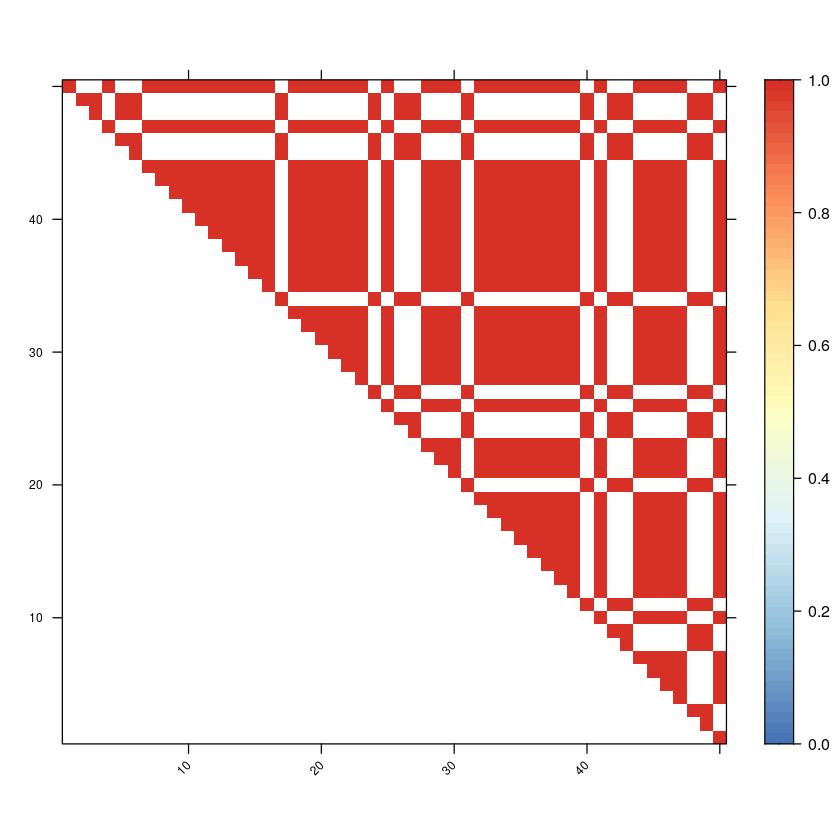

In [20]:
plot_sharing(a1$U$tPCA)

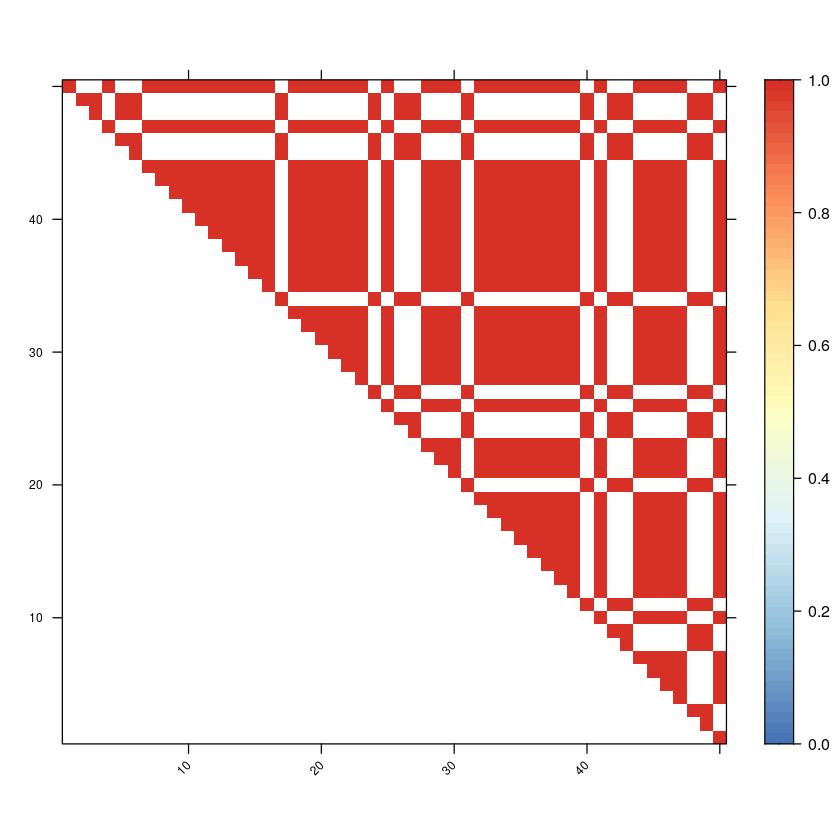

In [21]:
plot_sharing(a1$U$tFLASH)

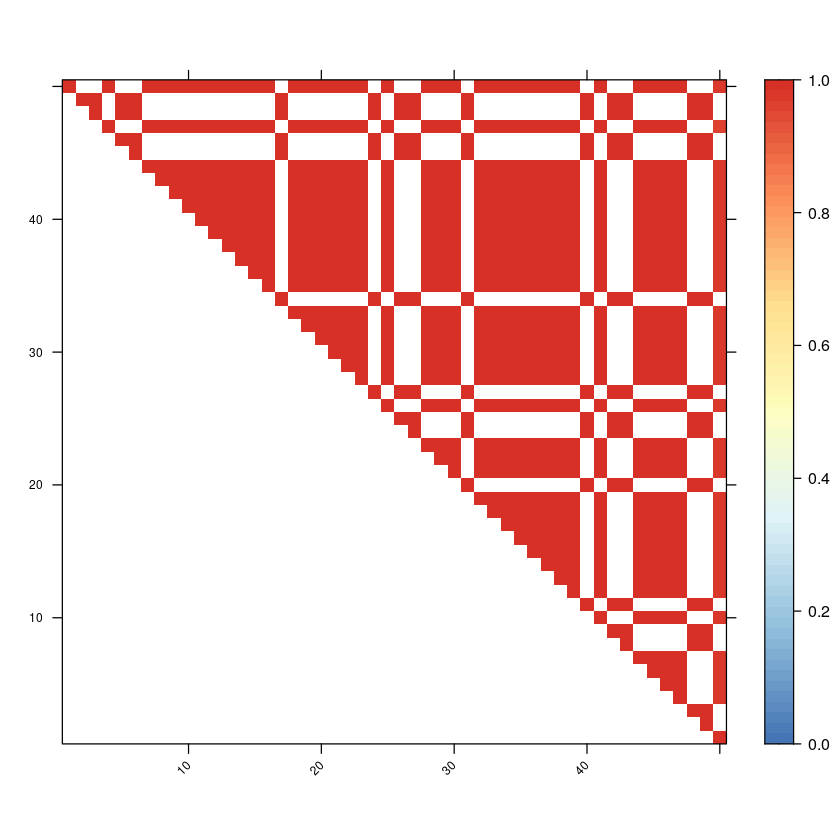

In [22]:
plot_sharing(a1$U$XX)

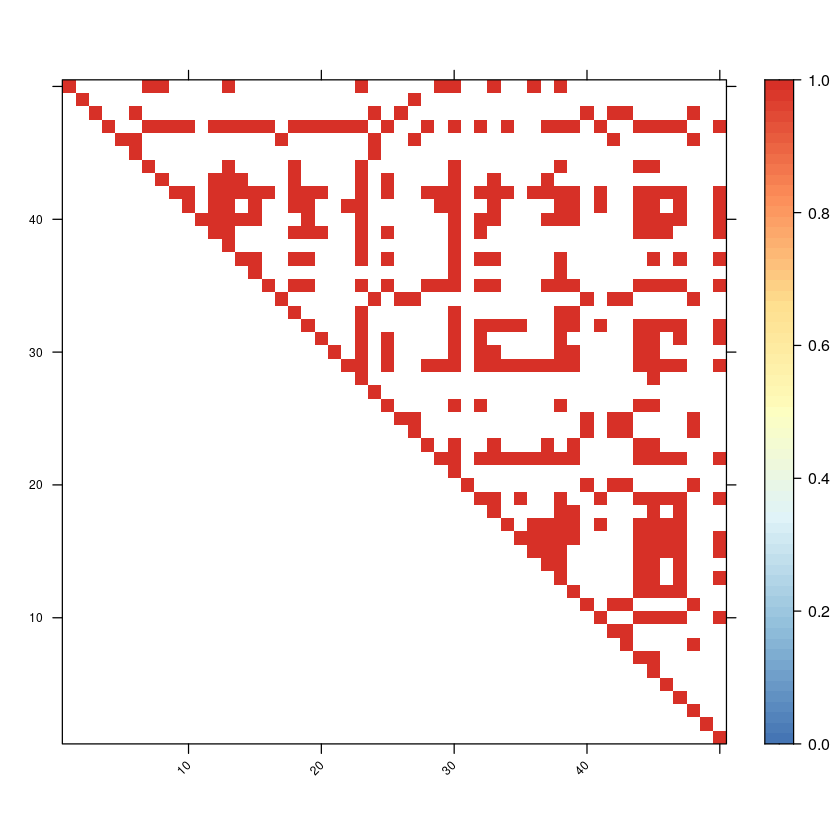

In [23]:
plot_sharing(a1$U$PCA_1)

For mixture simulated based on GTEx V8 ED matrices,

In [24]:
g1 = readRDS('gtex_mixture_identity.FL_PC3.ED.rds')

In [25]:
g1$loglik[length(g1$loglik)]

[1] 96.84946

In [26]:
g1$w

[1]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [6]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
[11]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
[16]  1.992800e-01 1.159619e-189  0.000000e+00  0.000000e+00  7.356171e-01
[21]  6.510289e-02

In [27]:
names(g1$U)[which(g1$w>tol)]

[1] "tFLASH" "tPCA"   "XX"

Again, most weights are on `tFLASH` and `tPCA`.

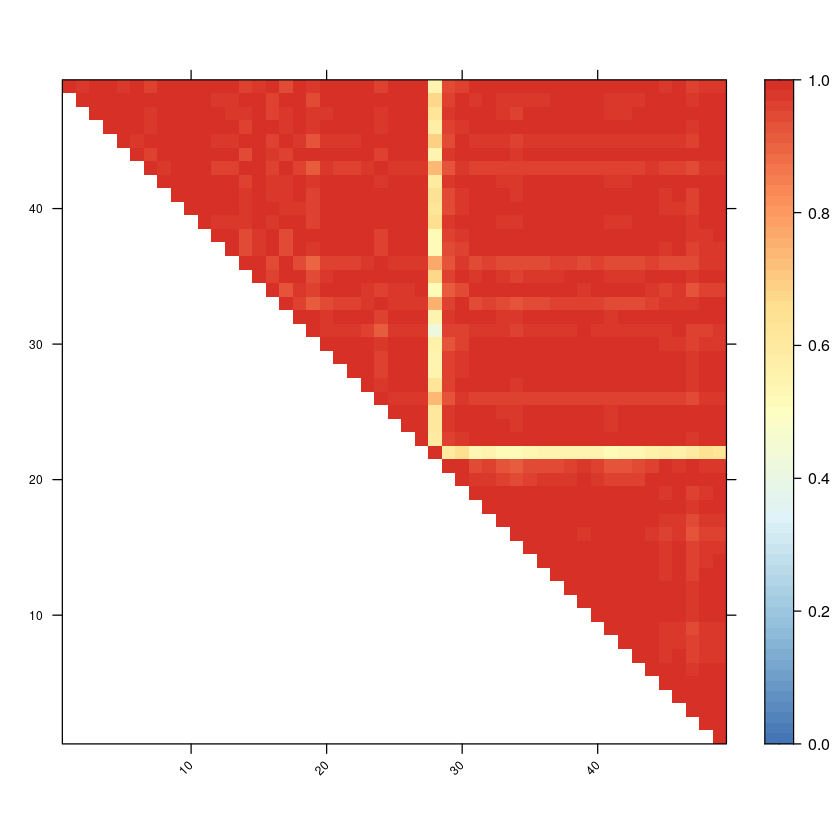

In [30]:
plot_sharing(g1$U$tFLASH)

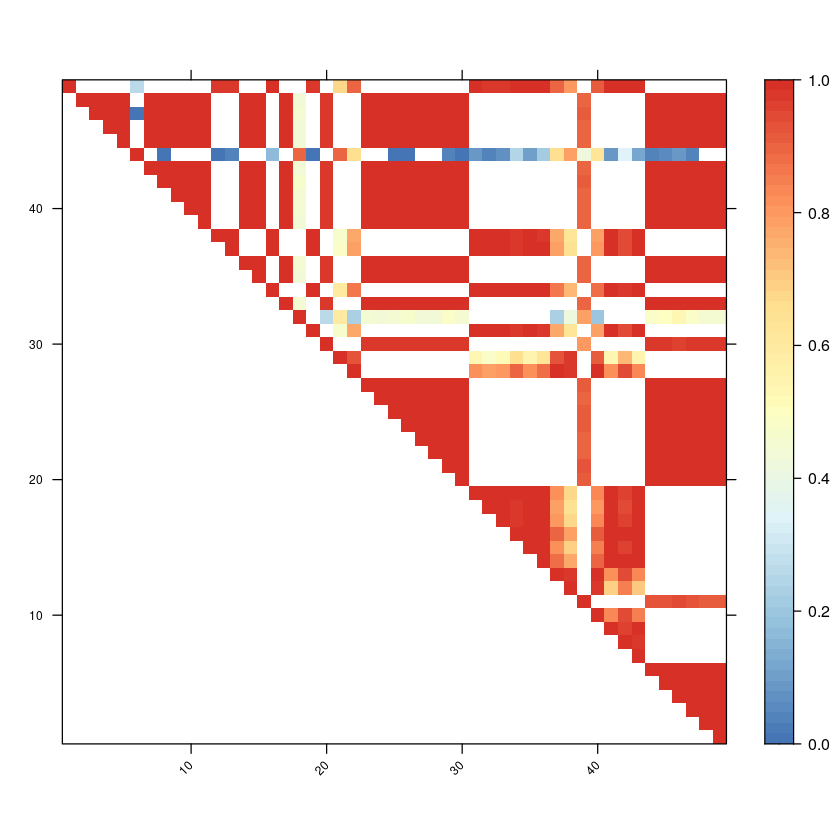

In [31]:
plot_sharing(g1$U$tPCA)

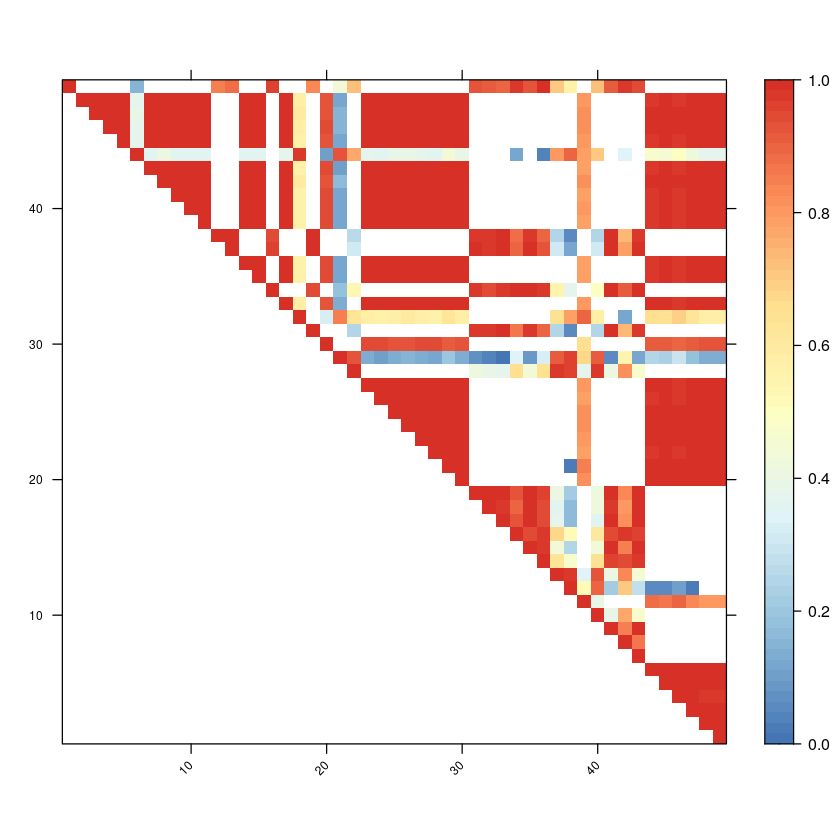

In [32]:
plot_sharing(g1$U$XX)

## Data-driven prior via TEEM

Currently two caveats: 

1. we don't have interface for bhat/sbhat so the result is based on z-score without transforming back to original scale bhat.
2. we don't have interface for non-identity residual covariance so the result is based on assuming identity covariance, although identity covariance is indeed the oracle covariance for the residual.

In [36]:
a2 = readRDS('artificial_mixture_identity.FLASH_PC3.TEEM.rds')

In [37]:
names(a2)

[1] "w"         "U"         "objective" "maxd"

In [38]:
a2$objective[length(a2$objective)]

[1] -1514460

In [39]:
a2$w

[1] 1.501686e-04 6.370631e-02 1.739402e-03 2.256258e-05 2.744157e-05
 [6] 4.013501e-04 1.000047e-04 1.762108e-02 5.943179e-01 3.214616e-01
[11] 4.521734e-04

In [40]:
names(a2$U)[which(a2$w>tol)]

[1] "FLASH_1" "FLASH_2" "FLASH_3" "FLASH_4" "FLASH_5" "tFLASH"  "PCA_1"  
 [8] "PCA_2"   "PCA_3"   "tPCA"    "XX"

**In TEEM since it does not preserve the rank of input, these names are not informative. Just showing how many are there compared to before.**

In [41]:
g2 = readRDS('gtex_mixture_identity.FLASH_PC3.TEEM.rds')

In [42]:
g2$objective[length(g2$objective)]

[1] -1525156

In [43]:
g2$w

[1]  1.719557e-63 1.397773e-143 1.688457e-142  7.846913e-93 3.244862e-107
 [6] 1.314552e-135 1.336535e-138  5.878649e-88 1.577159e-134 2.621484e-134
[11] 1.983842e-132 1.195918e-134 1.096910e-133 2.116053e-141 6.153096e-125
[16] 2.049477e-139 1.679131e-114 5.631910e-123 5.662857e-139  8.034692e-87
[21]  1.687193e-63 1.742688e-146 1.642108e-146  1.000000e+00  9.352107e-87

In [45]:
names(g2$U)[which(g2$w>tol)]

[1] "tPCA"

** with 100% weights making it a single component.**

## TEEM with oracle initialization

Here I initialize TEEM with the true mixture prior and weights under which the true `b` (effect size) was simulated from,

In [3]:
prior = readRDS("../data/prior_simulation.rds")

In [17]:
setwd('~/tmp/07-May-2020/')

In [10]:
a_data = readRDS('artificial_mixture_identity.FLASH_PC3.rds')
g_data = readRDS('gtex_mixture_identity.FLASH_PC3.rds')

In [5]:
names(prior)

[1] "gtex_mixture"          "artificial_mixture_50"

In [6]:
length(prior$gtex_mixture$U)

[1] 34

In [7]:
length(prior$gtex_mixture$w)

[1] 34

In [13]:
a_fit = mashr::teem_wrapper(a_data$mash_data, prior$artificial_mixture_50$U, w_init = prior$artificial_mixture_50$w)

In [14]:
g_fit = mashr::teem_wrapper(g_data$mash_data, prior$gtex_mixture$U, w_init = prior$gtex_mixture$w)

Compare the objectives with previous run using data driven initialization, loglik is higher for oracle init with GTEx based simulation, but not with the artificial simulation.

In [23]:
print(c(a_fit$objective[length(a_fit$objective)], a2$objective[length(a2$objective)], a_fit$objective[length(a_fit$objective)] - a2$objective[length(a2$objective)]))

[1] -1.514531e+06 -1.514460e+06 -7.093301e+01


In [24]:
print(c(g_fit$objective[length(g_fit$objective)], g2$objective[length(g2$objective)], g_fit$objective[length(g_fit$objective)] - g2$objective[length(g2$objective)]))

[1] -1521579.038 -1525155.707     3576.669


In [46]:
names(a_fit$U)[which(a_fit$w>tol)]

[1] "singleton_1"  "singleton_2"  "singleton_3"  "singleton_4"  "singleton_6" 
 [6] "singleton_7"  "singleton_8"  "singleton_9"  "singleton_10" "singleton_12"
[11] "singleton_13" "singleton_14" "singleton_15" "singleton_16" "singleton_17"
[16] "singleton_18" "singleton_20" "singleton_21" "singleton_22" "singleton_23"
[21] "singleton_24" "singleton_25" "singleton_26" "singleton_27" "singleton_28"
[26] "singleton_29" "singleton_30" "singleton_31" "singleton_32" "singleton_33"
[31] "singleton_35" "singleton_36" "singleton_37" "singleton_38" "singleton_39"
[36] "singleton_41" "singleton_43" "singleton_44" "singleton_45" "singleton_46"
[41] "singleton_47" "singleton_49" "singleton_50" "shared_1"     "shared_2"    
[46] "shared_3"     "shared_4"     "shared_5"     "paired_1"     "blocked_1"

In [48]:
a_fit$w[which(a_fit$w>tol)]

[1] 1.653742e-06 2.035599e-07 1.117793e-07 2.340475e-06 6.924966e-07
 [6] 6.229505e-07 1.567193e-07 4.791827e-07 2.502808e-03 7.516920e-07
[11] 2.862845e-07 1.317932e-07 6.934319e-08 1.853193e-07 1.914056e-05
[16] 6.707079e-07 9.337350e-08 2.657470e-08 7.461268e-06 1.304591e-07
[21] 2.730991e-07 6.811666e-08 4.236638e-07 1.920895e-06 2.209060e-06
[26] 3.578754e-06 1.643518e-07 1.302132e-08 3.839804e-07 3.893378e-08
[31] 1.888281e-07 4.865842e-08 1.723997e-07 3.277472e-07 3.852155e-07
[36] 4.684488e-07 1.037172e-07 7.582567e-08 5.462925e-07 6.667937e-08
[41] 6.290697e-06 2.958533e-06 2.300454e-06 1.820022e-01 6.375638e-02
[46] 7.162034e-01 3.483494e-02 5.000501e-04 4.177388e-05 1.002642e-04

In [47]:
names(g_fit$U)[which(g_fit$w>tol)]

[1] "ED_tFLASH"     "ED_tPCA"       "ED_XX"         "equal_effects"
[5] "simple_het_2"  "simple_het_3"

In [49]:
g_fit$w[which(g_fit$w>tol)]

[1] 5.000324e-05 5.000250e-05 8.954304e-01 1.043696e-01 5.000225e-05
[6] 5.000250e-05